# JC chain device simulation with large L

* In this notebook we will do some simulations for the Jaines-Cummings chain for system sizes attainable in lab $(L\sim 80)$

* We will look at the $XX$ and $ZZ$ correaltion functions and entanglement entropy for various choices of the time parameter $\theta$


In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from quimb import *
from quimb.tensor import *
import sympy as sym

import scipy as sp
from scipy import linalg

from JC_functions import *

## Lets look at the hopping probabilities for 8 different values of $\theta$ 

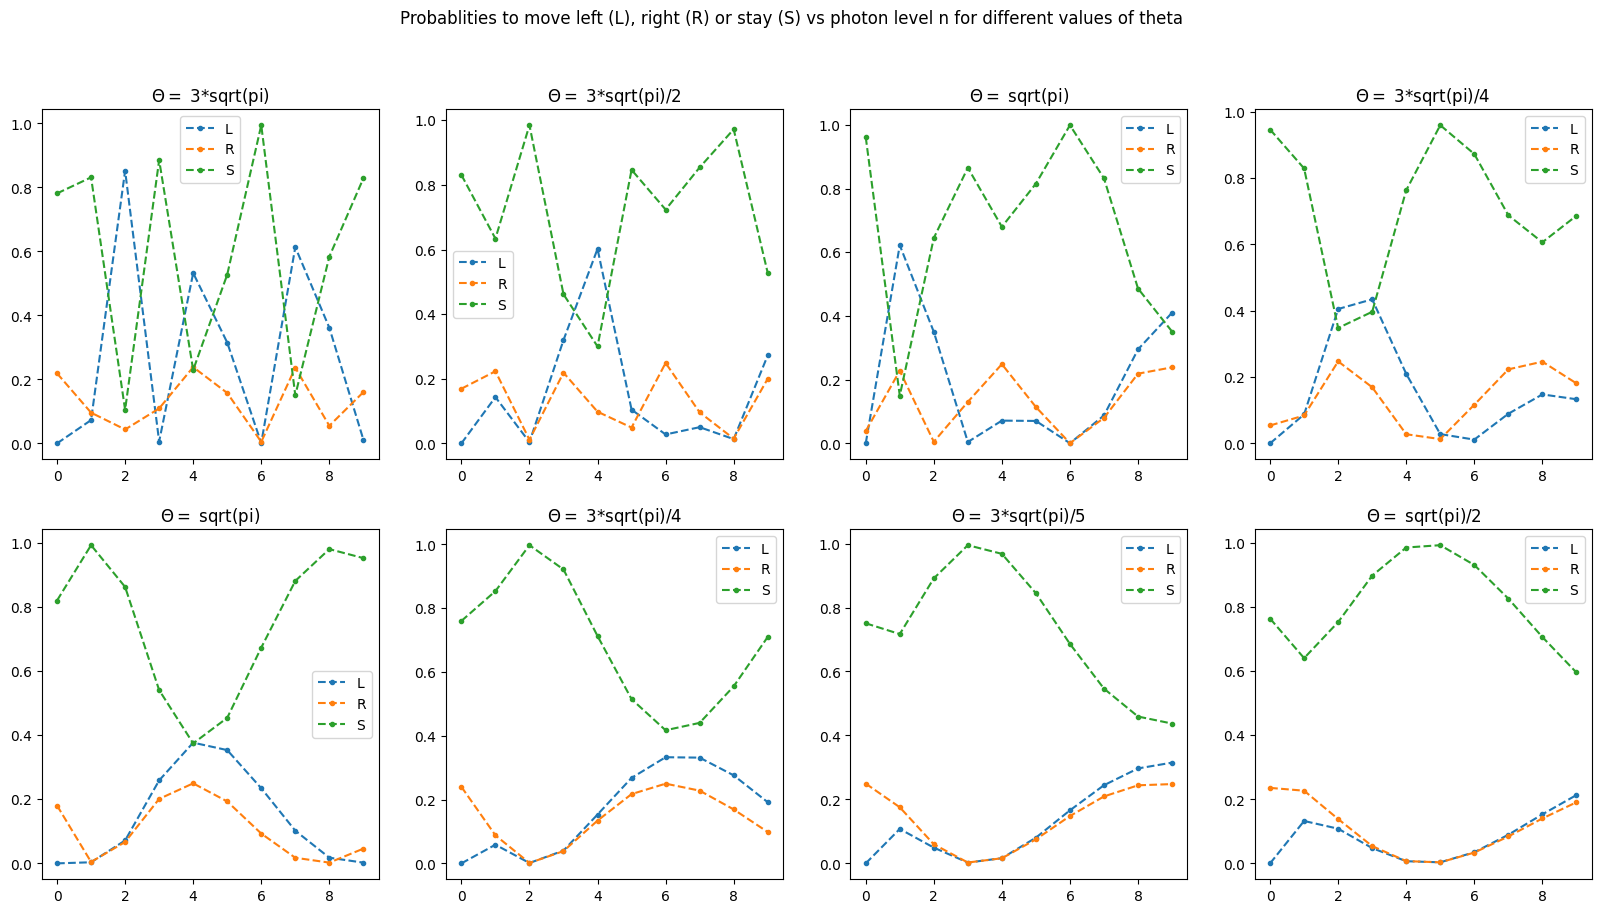

In [33]:
N= 10
theta_list = [3*np.sqrt(np.pi)/i for i in range(1,10)]
theta_sym_list = [sym.symbols(f'{3*sym.sqrt(sym.pi)/i}') for i in range(1,10)]


fig, axs = plt.subplots(2,4, figsize = (20,10))
for i in range(4):
    for j in range(2):
        L, S, R = [[], [],[]]
        for n in range(N):
            P = Hop_prob(n,theta_list[4*j + i])
            L.append(P[0])
            S.append(P[1])
            R.append(P[2])

        axs[j,i].plot(L, '--.', label = 'L')
        axs[j,i].plot(R, '--.', label = 'R')
        axs[j,i].plot(S, '--.', label = 'S')
        axs[j,i].set_title(f'$\Theta =$ {theta_sym_list[2*j+i]}')
        axs[j,i].legend()

fig.suptitle('Probablities to move left (L), right (R) or stay (S) vs photon level n for different values of theta')
plt.show()


# Now lets define some matrix product states:

## MPS for the choice of $\theta$ above

In [3]:
import time
t0 = time.time()
N_list = [10,30,100,200,400]
MPS_dictionary = {}

for N in N_list:
    chi = max(int(np.sqrt(N)), 15)
    for theta in theta_list:
        A_JC = MPS_JC_2site(chi,theta)
        BL = np.zeros((2, chi, chi))
        BL[0,0,0] = 1

        MPS_list = [A_JC for i in range(N)]
        MPS_list.insert(0, BL)
        MPS_list.append(BL)

        JC_MPS = MatrixProductState(MPS_list, shape = 'plr')
        JC_MPS.cyclic = False
        JC_MPS.normalize()

        MPS_dictionary[theta, N] = JC_MPS
    print(f'finished N = {N} at time {time.time()-t0}')

finished N = 10 at time 0.8491790294647217
finished N = 30 at time 3.6229867935180664
finished N = 100 at time 12.604419946670532
finished N = 200 at time 28.664814949035645
finished N = 400 at time 101.96428298950195


## MPS for Motzkin chain (for comparison)

In [4]:
pL, pR = [.2,.2]
MPS_Motz_dictionary = {}
for N in N_list:
    chi = max(int(N/4), 10)
    A_Motz = MPS_Motzkin(chi, pL,pR)
    BL = np.zeros((2, chi, chi))
    BL[0,0,0] = 1

    MPS_list1 = [A_Motz for i in range(N)]
    MPS_list1.insert(0, BL)
    MPS_list1.append(BL)

    Motz_MPS = MatrixProductState(MPS_list1, shape = 'plr')
    Motz_MPS.cyclic = False
    Motz_MPS.normalize()

    MPS_Motz_dictionary[N] = Motz_MPS


# Now lets plot correlation functions for the MPS above

In [ ]:
# for JC
Z_A, Z_B = [np.kron(pauli('Z'), np.eye(2)), np.kron(np.eye(2),pauli('Z'))]
X_A, X_B = [np.kron(pauli('X'), np.eye(2)), np.kron(np.eye(2),pauli('X'))]

#for Motz
Zspin1 = pauli('Z', dim=3)
Xspin1 = pauli('X', dim=3)


## ZZ and XX correlation function matrix for each theta:

In [ ]:
t0 = time.time()
x0 = 2

ZZ_data_JC, XX_data_JC = [{}, {}]
ZZ_data_motz, XX_data_motz = [{}, {}]
for N in N_list:
    x_list = list(range(2,N,int(N/20)+1))
    for theta in theta_list:
        ZZ, XX = [np.zeros(len(x_list)), np.zeros(len(x_list))]
        for i, x in enumerate(x_list):
            ZZ[i] = np.real(MPS_dictionary[theta,N].correlation(Z_A+Z_B, x0,x))
            XX[i] = np.real(MPS_dictionary[theta,N].correlation(X_A+X_B, x0,x))

    
        ZZ_data_JC[theta,N] = [x_list,ZZ]
        XX_data_JC[theta,N] = [x_list, XX]

    ZZmotz, XXmotz = [np.zeros(len(x_list)), np.zeros(len(x_list))]
    for i, x in enumerate(x_list):
        ZZmotz[i] = np.real(MPS_Motz_dictionary[N].correlation(Zspin1, x0,x))
        XXmotz[i] = np.real(MPS_Motz_dictionary[N].correlation(Xspin1, x0,x))
    
    ZZ_data_motz[N], XX_data_motz[N] = [[x_list, ZZmotz], [x_list, XXmotz]]

    print(f'finished mps family of size {N} at time {time.time()-t0}')

finished mps family of size 10 at time 0.31853795051574707
finished mps family of size 20 at time 1.1086528301239014
finished mps family of size 40 at time 9.944477796554565
finished mps family of size 60 at time 68.93515372276306
finished mps family of size 80 at time 384.04801082611084
finished mps family of size 100 at time 1645.3581449985504


## Grid of XX and ZZ correlation functions 


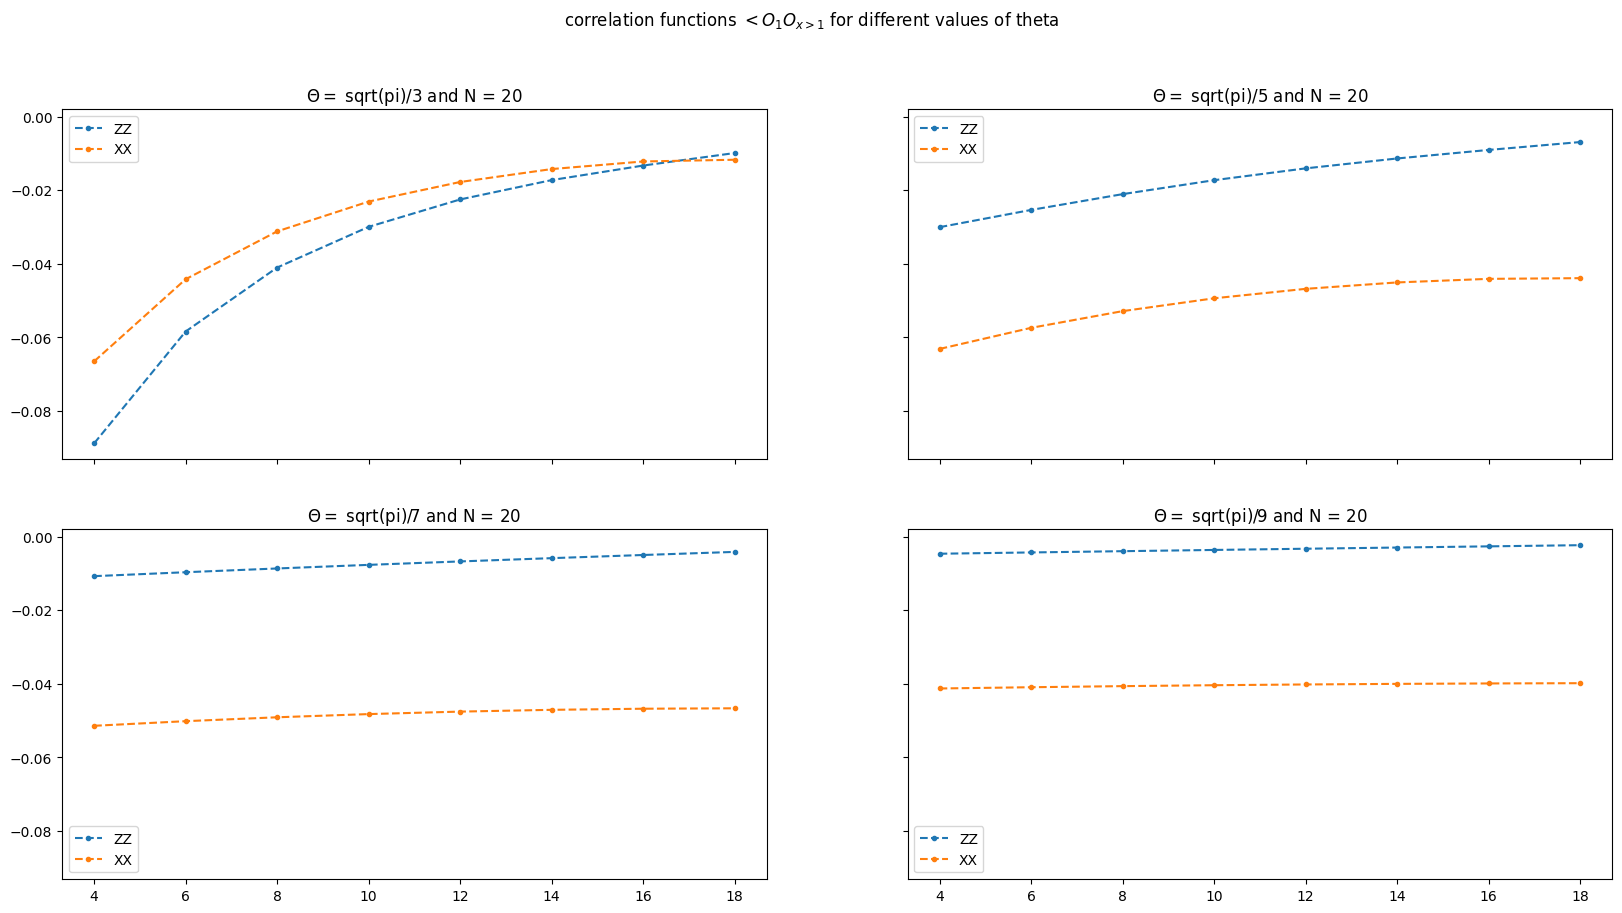

In [ ]:
n = 1
fig, axs = plt.subplots(2,2, figsize = (20,10), sharex=True, sharey=True)
for x in range(2):
    for y in range(2):
        x_data, Z_data, X_data = [ZZ_data_JC[theta_list[2*y+x], N_list[n]][0][1:],ZZ_data_JC[theta_list[2*y+x], N_list[n]][1][1:], XX_data_JC[theta_list[2*y+x], N_list[n]][1][1:]]
        
        axs[y,x].plot(x_data, Z_data, '.--', label = 'ZZ')
        axs[y,x].plot(x_data, X_data, '.--', label = 'XX')
        #axs[y,x].plot(ZZ_data_motz[1,2:], '.--', label = 'ZZ motz')
        #axs[y,x].plot(XX_data_motz[1,2:], '.--', label = 'XX motz')
        #axs[y,x].set_yscale('log')
        #axs[y,x].set_xscale('log')
        axs[y,x].set_title(f'$\Theta =$ {theta_sym_list[2*y+x]} and N = {N_list[n]}')
        axs[y,x].legend()


fig.suptitle('correlation functions $<O_1 O_{x>1}$ for different values of theta')
plt.show()

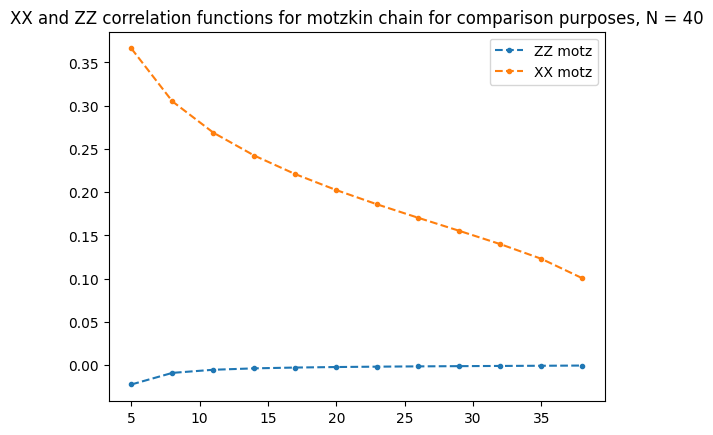

In [ ]:
n = 2
x_data, Z_data, X_data = [ZZ_data_motz[N_list[n]][0][1:],ZZ_data_motz[N_list[n]][1][1:], XX_data_motz[N_list[n]][1][1:]]

plt.plot(x_data,Z_data, '.--', label = 'ZZ motz')
plt.plot(x_data,X_data, '.--', label = 'XX motz')
plt.legend()
plt.title(f'XX and ZZ correlation functions for motzkin chain for comparison purposes, N = {N_list[n]}')
plt.show()

# $S_E$ array for each theta

t0 = time.time()
SE_data_JC = {}
SE_data_motz = {}
N_list = [10,30,100,200,400]

for N in N_list:
    x_list = list(range(2,N,int(N/15)+1))
    for theta in theta_list:
        SE_array = np.zeros(len(x_list))
        for i, x in enumerate(x_list):
            SE_array[i] = MPS_dictionary[theta, N].entropy(x)

        SE_data_JC[theta, N] = [x_list,SE_array]

    SE_motz = np.zeros(len(x_list))
    for i, x in enumerate(x_list):
            SE_motz[i] = MPS_Motz_dictionary[N].entropy(x)
    
    SE_data_motz[N] = [x_list,SE_motz]

    print(f'finished N = {N} at time {time.time()-t0}')

In [30]:
t0 = time.time()
SE_data_JC = {}
SE_data_motz = {}
N_list = [10,30,100,200,4000]

for N in N_list:
    x_data = list(range(2,N,int(N/20)+1))
    chi = max(int(np.sqrt(N)), 15)
    for theta in theta_list:
        M = M_JC(chi, theta)
        SE_data_JC[theta, N] = [x_data, [SE_fromM([M for i in range(N)], x) for x in x_data]]

    #Now motz data for comparison 
    M_motz = M_randwalk(chi, .2)
    SE_data_motz[N] = [x_data, [SE_fromM([M_motz for i in range(N)], x) for x in x_data]]
    
    print(f'done with N = {N} at time {time.time()-t0}')
    print('==================================')


done with N = 10 at time 0.0032036304473876953
done with N = 30 at time 0.012127876281738281
done with N = 100 at time 0.0349879264831543
done with N = 200 at time 0.0772249698638916
done with N = 4000 at time 11.491073608398438


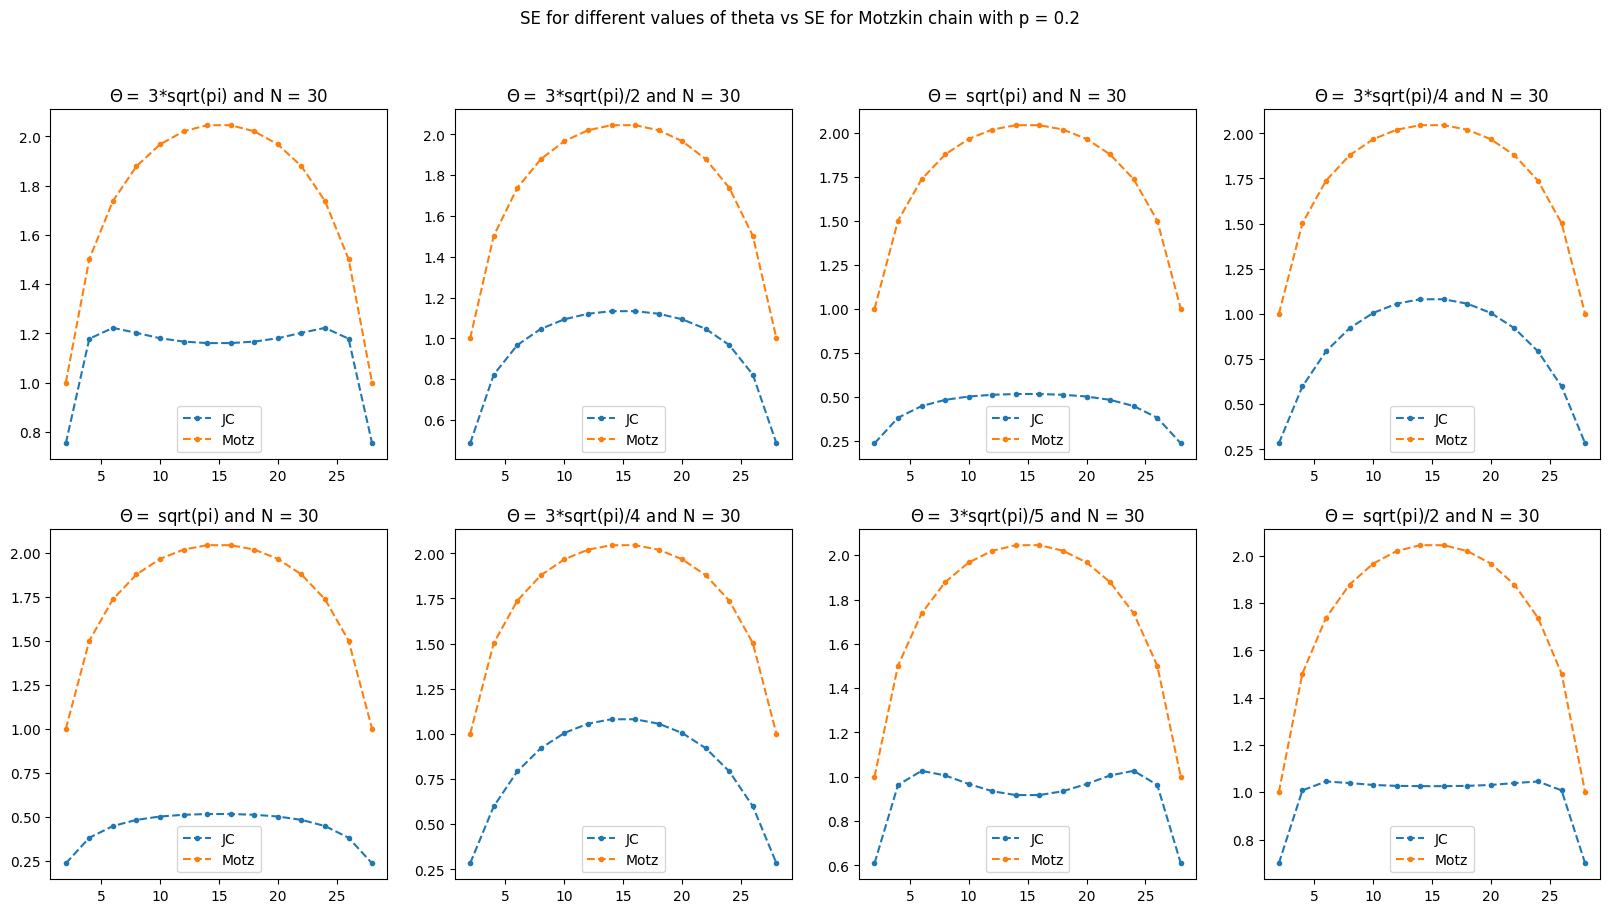

In [31]:
n=1
fig, axs = plt.subplots(2,4, figsize = (20,10))
for x in range(4):
    for y in range(2):
        x_list, SJC, SMotz = [SE_data_JC[theta_list[4*y+x], N_list[n]][0],SE_data_JC[theta_list[2*y+x], N_list[n]][1], SE_data_motz[N_list[n]][1]]

        axs[y,x].plot(x_list,SJC, '.--', label = 'JC')
        axs[y,x].plot(x_list,SMotz, '.--', label = 'Motz')
        axs[y,x].set_title(f'$\Theta =$ {theta_sym_list[2*y+x]} and N = {N_list[n]}')
        axs[y,x].legend()


fig.suptitle(f'SE for different values of theta vs SE for Motzkin chain with p = {pL}')
plt.show()

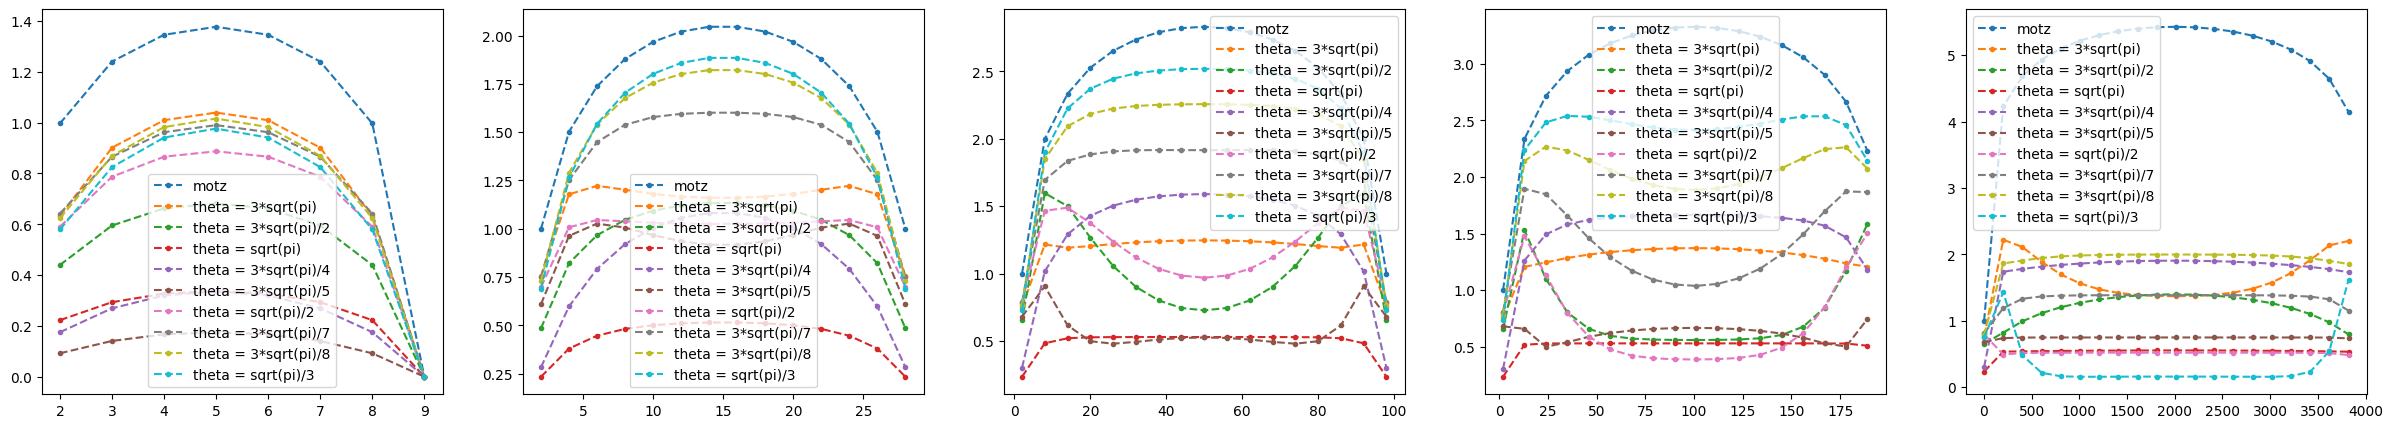

In [36]:
fig, axs = plt.subplots(1,len(N_list), figsize = (30,5))

for i,N in enumerate(N_list):
    axs[i].plot(SE_data_motz[N][0], SE_data_motz[N][1], '--.', label = f'motz')
    
    for j,theta in enumerate(theta_list):
        axs[i].plot(SE_data_JC[theta,N][0], SE_data_JC[theta,N][1], '--.', label = f'theta = {theta_sym_list[j]}')

    axs[i].legend()